In [27]:
import torch
import sklearn.datasets
import numpy as np
import torch.nn as nn
from typing import Iterator, List, Callable, Tuple
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

In [28]:
wine_dataset = sklearn.datasets.load_wine()

In [41]:
data, labels = wine_dataset['data'], wine_dataset['target']
data_float = []
for row in data:
  data_float.append([float(el) for el in row])
train_data, validation_data, train_labels, validation_labels = train_test_split(data_float, labels, test_size=0.1, random_state=42)
train_data, test_data, train_labels, test_labels = train_test_split(data_float, labels, test_size=0.1, random_state=42)

18


In [30]:
class WineDataset(Dataset):
  def __init__(self, data, labels, transform=None):
    self.data = data
    self.label = labels

  def __getitem__(self, idx):
    item_data = self.data[idx]
    label = self.label[idx]

    item_data_tensor = torch.tensor(item_data)
    label_tensor = torch.tensor(label)

    return item_data_tensor, label_tensor

  def __len__(self):
    return len(self.data)

In [31]:
train_dataset = WineDataset(data=train_data, labels=train_labels)
validation_dataset = WineDataset(data=validation_data, labels=validation_labels)
test_dataset = WineDataset(data=test_data, labels=test_labels)

In [32]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
validation_dataloader = DataLoader(dataset=validation_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=True)

In [44]:
class WineClassificator(nn.Module):
  def __init__(self, 
                 input_size: int, 
                 hidden_size_1: int, 
                 hidden_size_2: int,
                 activation_fn: Callable):
    super().__init__()
    self.input_size = input_size
    self.hidden_size_1 = hidden_size_1
    self.hidden_size_2 = hidden_size_2
    self.layer_1 = nn.Linear(input_size, hidden_size_1)
    self.dropout_1 = nn.Dropout(p=0.3)
    self.layer_2 = nn.Linear(hidden_size_1, hidden_size_2)
    self.dropout_2 = nn.Dropout(p=0.5)
    self.output_layer = nn.Linear(hidden_size_2, 3)
    self.activation_fn = activation_fn

  def forward(self, x):
    h1 = self.activation_fn(self.layer_1(x))
    dropout_h1 = self.dropout_1(h1)
    h2 = self.activation_fn(self.layer_2(dropout_h1))
    dropout_h2 = self.dropout_2(h2)
    out = self.output_layer(dropout_h2)

    return out

In [34]:
def train_epoch(model, train_dataloader, loss_crt, optimizer):
    """
    model: Model object 
    train_dataloader: DataLoader over the training dataset
    loss_crt: loss function object
    optimizer: Optimizer object

    The function returns: 
     - the epoch training loss, which is an average over the individual batch
       losses
     - the predictions made by the model
     - the labels 
    """
    model.train()
    epoch_loss = 0.0
    num_batches = len(train_dataloader)
    predictions = []
    labels = []
    for idx, batch in tqdm(enumerate(train_dataloader)):
        batch_data, batch_labels = batch

        output = model(batch_data)
        batch_predictions = torch.argmax(output, dim=1)
        
        predictions += batch_predictions.tolist()
        labels += batch_labels.squeeze().tolist()

        loss = loss_crt(output, batch_labels)
        loss_scalar = loss.item()
        # print("  epoch %d, batch %d/%d, loss=%f" % (
        #     epoch_idx, idx, num_batches, loss_scalar
        # ))

        loss.backward()

        optimizer.step()
        model.zero_grad()

        epoch_loss += loss_scalar

    epoch_loss = epoch_loss/num_batches

    return epoch_loss, predictions, labels

def eval_epoch(model, val_dataloader, loss_crt):
    """
    model: Model object 
    val_dataloader: DataLoader over the validation dataset
    loss_crt: loss function object

    The function returns: 
     - the epoch validation loss, which is an average over the individual batch
       losses
     - the predictions made by the model
     - the labels 
    """
    model.eval()
    epoch_loss = 0.0
    num_batches = len(val_dataloader)
    predictions = []
    labels = []
    with torch.no_grad():
        for idx, batch in tqdm(enumerate(val_dataloader)):
            batch_data, batch_labels = batch
            
            output = model(batch_data)
            batch_predictions = torch.argmax(output, dim=1)
        
            predictions += batch_predictions.tolist()
            labels += batch_labels.squeeze().tolist()

            loss = loss_crt(output, batch_labels)
            loss_scalar = loss.item()

            epoch_loss += loss_scalar

    epoch_loss = epoch_loss/num_batches

    return epoch_loss, predictions, labels

In [35]:
def compute_accuracy(predictions: List[int], labels:List[int]) -> float:
    """
    Compute accuracy given the predictions of a binary classifier and the 
    ground truth label.
    predictions: list of model predictions (0 or 1)
    labels: list of ground truth labels (0 or 1)
    """
    num_correct = len([(p,l) for (p,l) in zip(predictions,labels) if p==l])
    epoch_accuracy = num_correct/len(labels)
    
    return epoch_accuracy

In [45]:
hyperparams = {
    'lr': 0.001,
    'num_epochs': 100,
    'hidden_size_1': 256,
    'hidden_size_2': 128,
    'activation_fn': nn.ReLU()
}

model = WineClassificator(
    input_size = 13,
    hidden_size_1 = hyperparams['hidden_size_1'],
    hidden_size_2 = hyperparams['hidden_size_2'],
    activation_fn = hyperparams['activation_fn']
)

loss_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=hyperparams['lr'])

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_acc = 0.0

for epoch_idx in range(hyperparams['num_epochs']):
    train_epoch_loss, train_predictions, train_labels = train_epoch(
        model, 
        train_dataloader, 
        loss_criterion, 
        optimizer
    )
    val_epoch_loss, val_predictions, val_labels = eval_epoch(
        model,
        validation_dataloader,
        loss_criterion,
    )
    train_acc = compute_accuracy(train_predictions, train_labels)
    val_acc = compute_accuracy(val_predictions, val_labels)
    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print("epoch %d, train loss=%f, train acc=%f, val loss=%f, val acc=%f" % (
        epoch_idx, 
        train_epoch_loss,
        train_acc,
        val_epoch_loss,
        val_acc
    ))

10it [00:00, 288.65it/s]
2it [00:00, 809.32it/s]


epoch 0, train loss=18.887127, train acc=0.287500, val loss=1.423050, val acc=0.555556


10it [00:00, 380.48it/s]
2it [00:00, 908.25it/s]


epoch 1, train loss=12.107310, train acc=0.331250, val loss=9.178057, val acc=0.388889


10it [00:00, 412.30it/s]
2it [00:00, 953.79it/s]


epoch 2, train loss=8.903266, train acc=0.368750, val loss=1.264893, val acc=0.500000


10it [00:00, 401.41it/s]
2it [00:00, 784.64it/s]


epoch 3, train loss=4.827022, train acc=0.406250, val loss=0.905573, val acc=0.555556


10it [00:00, 373.83it/s]
2it [00:00, 673.51it/s]


epoch 4, train loss=3.290064, train acc=0.437500, val loss=1.517032, val acc=0.222222


10it [00:00, 354.99it/s]
2it [00:00, 318.40it/s]


epoch 5, train loss=2.369084, train acc=0.362500, val loss=0.965330, val acc=0.388889


10it [00:00, 478.75it/s]
2it [00:00, 357.66it/s]


epoch 6, train loss=1.959551, train acc=0.431250, val loss=1.109818, val acc=0.388889


10it [00:00, 374.83it/s]
2it [00:00, 1153.87it/s]


epoch 7, train loss=1.645955, train acc=0.400000, val loss=1.079261, val acc=0.611111


10it [00:00, 403.33it/s]
2it [00:00, 667.56it/s]


epoch 8, train loss=1.232068, train acc=0.456250, val loss=1.090513, val acc=0.444444


10it [00:00, 461.14it/s]
2it [00:00, 466.68it/s]


epoch 9, train loss=1.190490, train acc=0.418750, val loss=1.074494, val acc=0.666667


10it [00:00, 394.77it/s]
2it [00:00, 842.65it/s]


epoch 10, train loss=1.283129, train acc=0.406250, val loss=1.062645, val acc=0.666667


10it [00:00, 422.62it/s]
2it [00:00, 854.50it/s]


epoch 11, train loss=1.091586, train acc=0.475000, val loss=1.045244, val acc=0.722222


10it [00:00, 391.75it/s]
2it [00:00, 770.59it/s]


epoch 12, train loss=1.278291, train acc=0.406250, val loss=0.936097, val acc=0.444444


10it [00:00, 460.16it/s]
2it [00:00, 809.32it/s]


epoch 13, train loss=1.183647, train acc=0.400000, val loss=1.023935, val acc=0.666667


10it [00:00, 455.55it/s]
2it [00:00, 826.79it/s]


epoch 14, train loss=1.177044, train acc=0.443750, val loss=1.073513, val acc=0.666667


10it [00:00, 448.14it/s]
2it [00:00, 715.51it/s]


epoch 15, train loss=1.093187, train acc=0.537500, val loss=1.030387, val acc=0.555556


10it [00:00, 451.54it/s]
2it [00:00, 513.22it/s]


epoch 16, train loss=1.117777, train acc=0.456250, val loss=1.037960, val acc=0.555556


10it [00:00, 460.21it/s]
2it [00:00, 957.60it/s]


epoch 17, train loss=1.003436, train acc=0.487500, val loss=1.032992, val acc=0.666667


10it [00:00, 312.68it/s]
2it [00:00, 840.46it/s]


epoch 18, train loss=0.958746, train acc=0.537500, val loss=0.990450, val acc=0.666667


10it [00:00, 383.19it/s]
2it [00:00, 673.19it/s]


epoch 19, train loss=1.022571, train acc=0.512500, val loss=0.931988, val acc=0.722222


10it [00:00, 255.03it/s]
2it [00:00, 648.52it/s]


epoch 20, train loss=1.020988, train acc=0.556250, val loss=0.949695, val acc=0.555556


10it [00:00, 446.61it/s]
2it [00:00, 283.45it/s]


epoch 21, train loss=1.022772, train acc=0.500000, val loss=0.870178, val acc=0.722222


10it [00:00, 363.53it/s]
2it [00:00, 642.76it/s]


epoch 22, train loss=0.988535, train acc=0.531250, val loss=0.998364, val acc=0.722222


10it [00:00, 451.43it/s]
2it [00:00, 577.21it/s]


epoch 23, train loss=1.050756, train acc=0.506250, val loss=0.839492, val acc=0.555556


10it [00:00, 378.40it/s]
2it [00:00, 775.07it/s]


epoch 24, train loss=1.010578, train acc=0.518750, val loss=1.001403, val acc=0.666667


10it [00:00, 422.49it/s]
2it [00:00, 826.30it/s]


epoch 25, train loss=1.044661, train acc=0.506250, val loss=0.744606, val acc=0.611111


10it [00:00, 392.21it/s]
2it [00:00, 848.79it/s]


epoch 26, train loss=1.114240, train acc=0.481250, val loss=0.980014, val acc=0.666667


10it [00:00, 405.87it/s]
2it [00:00, 859.05it/s]


epoch 27, train loss=1.065105, train acc=0.493750, val loss=0.887478, val acc=0.666667


10it [00:00, 348.34it/s]
2it [00:00, 770.66it/s]


epoch 28, train loss=0.951438, train acc=0.562500, val loss=0.778300, val acc=0.666667


10it [00:00, 440.88it/s]
2it [00:00, 1096.98it/s]


epoch 29, train loss=0.997070, train acc=0.537500, val loss=0.883659, val acc=0.666667


10it [00:00, 386.45it/s]
2it [00:00, 865.79it/s]


epoch 30, train loss=0.959892, train acc=0.512500, val loss=0.617997, val acc=0.666667


10it [00:00, 304.30it/s]
2it [00:00, 851.12it/s]


epoch 31, train loss=1.016746, train acc=0.500000, val loss=0.720634, val acc=0.722222


10it [00:00, 372.73it/s]
2it [00:00, 905.51it/s]


epoch 32, train loss=0.907333, train acc=0.562500, val loss=0.872188, val acc=0.722222


10it [00:00, 345.80it/s]
2it [00:00, 957.82it/s]


epoch 33, train loss=0.934751, train acc=0.568750, val loss=0.687049, val acc=0.666667


10it [00:00, 357.95it/s]
2it [00:00, 874.45it/s]


epoch 34, train loss=1.012160, train acc=0.562500, val loss=0.875766, val acc=0.722222


10it [00:00, 403.85it/s]
2it [00:00, 810.89it/s]


epoch 35, train loss=0.958328, train acc=0.512500, val loss=0.889367, val acc=0.666667


10it [00:00, 321.83it/s]
2it [00:00, 854.41it/s]


epoch 36, train loss=0.890836, train acc=0.537500, val loss=0.751717, val acc=0.722222


10it [00:00, 421.31it/s]
2it [00:00, 951.31it/s]


epoch 37, train loss=0.978427, train acc=0.550000, val loss=0.802147, val acc=0.611111


10it [00:00, 390.68it/s]
2it [00:00, 900.84it/s]


epoch 38, train loss=0.889799, train acc=0.575000, val loss=0.671362, val acc=0.666667


10it [00:00, 371.10it/s]
2it [00:00, 860.63it/s]


epoch 39, train loss=0.951262, train acc=0.550000, val loss=0.906610, val acc=0.722222


10it [00:00, 312.88it/s]
2it [00:00, 825.24it/s]


epoch 40, train loss=0.924555, train acc=0.550000, val loss=0.776461, val acc=0.666667


10it [00:00, 376.05it/s]
2it [00:00, 868.39it/s]


epoch 41, train loss=0.922160, train acc=0.537500, val loss=0.861531, val acc=0.722222


10it [00:00, 320.35it/s]
2it [00:00, 921.62it/s]


epoch 42, train loss=0.906115, train acc=0.537500, val loss=0.848384, val acc=0.666667


10it [00:00, 329.72it/s]
2it [00:00, 981.93it/s]


epoch 43, train loss=0.890638, train acc=0.587500, val loss=0.628942, val acc=0.722222


10it [00:00, 339.45it/s]
2it [00:00, 741.70it/s]


epoch 44, train loss=0.891506, train acc=0.587500, val loss=0.725039, val acc=0.722222


10it [00:00, 422.37it/s]
2it [00:00, 771.01it/s]


epoch 45, train loss=0.876291, train acc=0.556250, val loss=0.718720, val acc=0.722222


10it [00:00, 401.12it/s]
2it [00:00, 963.10it/s]


epoch 46, train loss=0.845923, train acc=0.581250, val loss=0.620957, val acc=0.666667


10it [00:00, 416.70it/s]
2it [00:00, 491.89it/s]


epoch 47, train loss=0.847548, train acc=0.606250, val loss=0.633477, val acc=0.722222


10it [00:00, 319.88it/s]
2it [00:00, 1038.84it/s]


epoch 48, train loss=0.942451, train acc=0.562500, val loss=0.724737, val acc=0.722222


10it [00:00, 330.68it/s]
2it [00:00, 681.95it/s]


epoch 49, train loss=0.842832, train acc=0.600000, val loss=0.895181, val acc=0.722222


10it [00:00, 367.44it/s]
2it [00:00, 977.58it/s]


epoch 50, train loss=0.850511, train acc=0.612500, val loss=0.658050, val acc=0.666667


10it [00:00, 239.83it/s]
2it [00:00, 630.20it/s]


epoch 51, train loss=0.779310, train acc=0.612500, val loss=0.556422, val acc=0.722222


10it [00:00, 364.09it/s]
2it [00:00, 1012.51it/s]


epoch 52, train loss=0.827733, train acc=0.618750, val loss=0.529140, val acc=0.722222


10it [00:00, 272.74it/s]
2it [00:00, 1123.27it/s]


epoch 53, train loss=0.952944, train acc=0.550000, val loss=0.838262, val acc=0.722222


10it [00:00, 319.91it/s]
2it [00:00, 853.80it/s]


epoch 54, train loss=0.830978, train acc=0.593750, val loss=0.699450, val acc=0.666667


10it [00:00, 373.13it/s]
2it [00:00, 923.96it/s]


epoch 55, train loss=0.914701, train acc=0.581250, val loss=0.608978, val acc=0.722222


10it [00:00, 369.81it/s]
2it [00:00, 394.96it/s]


epoch 56, train loss=0.833352, train acc=0.606250, val loss=0.832024, val acc=0.666667


10it [00:00, 430.20it/s]
2it [00:00, 380.85it/s]


epoch 57, train loss=0.835728, train acc=0.606250, val loss=0.681516, val acc=0.666667


10it [00:00, 340.92it/s]
2it [00:00, 1163.15it/s]


epoch 58, train loss=0.774615, train acc=0.581250, val loss=0.732836, val acc=0.777778


10it [00:00, 379.38it/s]
2it [00:00, 731.99it/s]


epoch 59, train loss=0.877341, train acc=0.600000, val loss=0.838556, val acc=0.722222


10it [00:00, 477.29it/s]
2it [00:00, 1166.22it/s]


epoch 60, train loss=0.829479, train acc=0.568750, val loss=0.857262, val acc=0.722222


10it [00:00, 405.74it/s]
2it [00:00, 671.30it/s]


epoch 61, train loss=0.834935, train acc=0.593750, val loss=0.530566, val acc=0.722222


10it [00:00, 345.49it/s]
2it [00:00, 742.42it/s]


epoch 62, train loss=0.810354, train acc=0.643750, val loss=0.927614, val acc=0.722222


10it [00:00, 378.74it/s]
2it [00:00, 944.66it/s]


epoch 63, train loss=0.820496, train acc=0.612500, val loss=0.638364, val acc=0.722222


10it [00:00, 323.76it/s]
2it [00:00, 851.29it/s]


epoch 64, train loss=0.791806, train acc=0.600000, val loss=0.655552, val acc=0.722222


10it [00:00, 352.51it/s]
2it [00:00, 298.34it/s]


epoch 65, train loss=0.817479, train acc=0.625000, val loss=0.673213, val acc=0.722222


10it [00:00, 437.18it/s]
2it [00:00, 726.73it/s]


epoch 66, train loss=0.777290, train acc=0.612500, val loss=0.799915, val acc=0.722222


10it [00:00, 289.58it/s]
2it [00:00, 694.59it/s]


epoch 67, train loss=0.748854, train acc=0.643750, val loss=0.624977, val acc=0.777778


10it [00:00, 357.18it/s]
2it [00:00, 794.38it/s]


epoch 68, train loss=0.798088, train acc=0.600000, val loss=0.727855, val acc=0.722222


10it [00:00, 330.43it/s]
2it [00:00, 1215.74it/s]


epoch 69, train loss=0.813703, train acc=0.612500, val loss=0.608372, val acc=0.722222


10it [00:00, 367.90it/s]
2it [00:00, 741.04it/s]


epoch 70, train loss=0.776891, train acc=0.650000, val loss=0.886436, val acc=0.722222


10it [00:00, 403.91it/s]
2it [00:00, 777.66it/s]


epoch 71, train loss=0.867050, train acc=0.575000, val loss=0.772222, val acc=0.666667


10it [00:00, 405.27it/s]
2it [00:00, 777.30it/s]


epoch 72, train loss=0.796059, train acc=0.643750, val loss=0.676625, val acc=0.666667


10it [00:00, 384.92it/s]
2it [00:00, 811.98it/s]


epoch 73, train loss=0.844681, train acc=0.512500, val loss=0.824346, val acc=0.722222


10it [00:00, 348.13it/s]
2it [00:00, 833.03it/s]


epoch 74, train loss=0.821895, train acc=0.606250, val loss=0.952015, val acc=0.722222


10it [00:00, 325.94it/s]
2it [00:00, 638.79it/s]


epoch 75, train loss=0.832808, train acc=0.581250, val loss=0.817219, val acc=0.722222


10it [00:00, 289.54it/s]
2it [00:00, 914.49it/s]


epoch 76, train loss=0.817471, train acc=0.606250, val loss=0.694917, val acc=0.666667


10it [00:00, 314.27it/s]
2it [00:00, 343.96it/s]


epoch 77, train loss=0.860984, train acc=0.625000, val loss=0.391634, val acc=0.777778


10it [00:00, 364.85it/s]
2it [00:00, 796.64it/s]


epoch 78, train loss=0.809834, train acc=0.562500, val loss=0.687650, val acc=0.722222


10it [00:00, 330.78it/s]
2it [00:00, 694.65it/s]


epoch 79, train loss=0.786476, train acc=0.637500, val loss=0.859783, val acc=0.722222


10it [00:00, 332.24it/s]
2it [00:00, 497.01it/s]


epoch 80, train loss=0.815493, train acc=0.600000, val loss=0.732908, val acc=0.722222


10it [00:00, 346.62it/s]
2it [00:00, 740.26it/s]


epoch 81, train loss=0.794597, train acc=0.568750, val loss=0.564982, val acc=0.722222


10it [00:00, 362.33it/s]
2it [00:00, 787.07it/s]


epoch 82, train loss=0.844424, train acc=0.593750, val loss=0.539533, val acc=0.666667


10it [00:00, 372.23it/s]
2it [00:00, 833.94it/s]


epoch 83, train loss=0.751948, train acc=0.612500, val loss=0.543970, val acc=0.722222


10it [00:00, 319.44it/s]
2it [00:00, 585.80it/s]


epoch 84, train loss=0.731280, train acc=0.612500, val loss=0.605400, val acc=0.722222


10it [00:00, 250.79it/s]
2it [00:00, 916.29it/s]


epoch 85, train loss=0.796037, train acc=0.625000, val loss=0.370600, val acc=0.722222


10it [00:00, 340.04it/s]
2it [00:00, 740.59it/s]


epoch 86, train loss=0.764536, train acc=0.656250, val loss=0.481989, val acc=0.722222


10it [00:00, 314.10it/s]
2it [00:00, 666.45it/s]


epoch 87, train loss=0.740291, train acc=0.600000, val loss=0.878683, val acc=0.722222


10it [00:00, 320.61it/s]
2it [00:00, 671.95it/s]


epoch 88, train loss=0.790764, train acc=0.600000, val loss=0.952518, val acc=0.722222


10it [00:00, 365.56it/s]
2it [00:00, 893.74it/s]


epoch 89, train loss=0.746116, train acc=0.612500, val loss=0.602974, val acc=0.722222


10it [00:00, 351.37it/s]
2it [00:00, 811.20it/s]


epoch 90, train loss=0.756735, train acc=0.606250, val loss=0.821766, val acc=0.722222


10it [00:00, 327.66it/s]
2it [00:00, 877.10it/s]


epoch 91, train loss=0.788933, train acc=0.593750, val loss=0.441347, val acc=0.722222


10it [00:00, 361.18it/s]
2it [00:00, 767.20it/s]


epoch 92, train loss=0.757434, train acc=0.612500, val loss=0.567444, val acc=0.666667


10it [00:00, 288.85it/s]
2it [00:00, 812.61it/s]


epoch 93, train loss=0.740436, train acc=0.562500, val loss=0.635248, val acc=0.666667


10it [00:00, 278.17it/s]
2it [00:00, 867.49it/s]


epoch 94, train loss=0.704357, train acc=0.618750, val loss=0.645390, val acc=0.722222


10it [00:00, 339.78it/s]
2it [00:00, 907.56it/s]


epoch 95, train loss=0.817545, train acc=0.593750, val loss=0.771391, val acc=0.722222


10it [00:00, 303.07it/s]
2it [00:00, 578.09it/s]


epoch 96, train loss=0.715519, train acc=0.643750, val loss=0.467264, val acc=0.722222


10it [00:00, 270.09it/s]
2it [00:00, 776.58it/s]


epoch 97, train loss=0.776814, train acc=0.600000, val loss=0.569015, val acc=0.722222


10it [00:00, 320.35it/s]
2it [00:00, 309.05it/s]


epoch 98, train loss=0.803713, train acc=0.606250, val loss=0.440770, val acc=0.722222


10it [00:00, 299.04it/s]
2it [00:00, 421.07it/s]

epoch 99, train loss=0.705765, train acc=0.612500, val loss=0.563239, val acc=0.722222


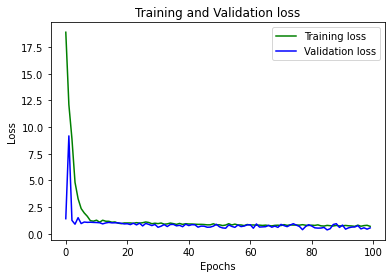

In [46]:
%matplotlib inline
NUM_EPOCHS=hyperparams['num_epochs']
plt.plot(range(0,len(train_losses)), train_losses, 'g', label='Training loss')
plt.plot(range(0,len(train_losses)), val_losses, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Neaplicand dropout dupa liniaritati, graficul pentru loss arata in felul urmator:
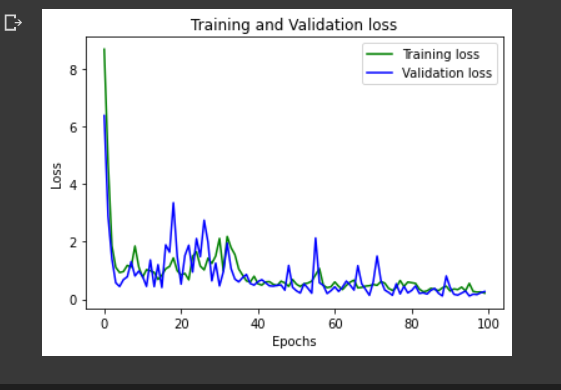

Se poate observa cum dupa ce am aplicat dropout, s-a stabilizat loss-ul

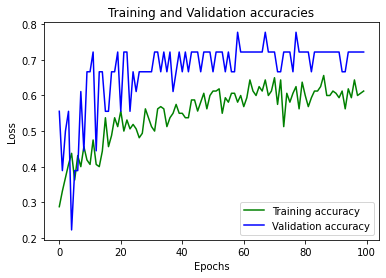

In [47]:
plt.plot(range(0,len(train_accuracies)), train_accuracies, 'g', label='Training accuracy')
plt.plot(range(0,len(train_accuracies)), val_accuracies, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracies')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Acurateatea inainte de a aplica dropout:

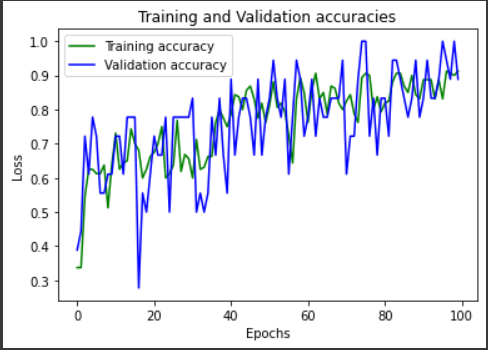

Se poate observa cum a scazut acuratetea pe date, dar modelul a reusit sa generalizeze destul de bine astfel incat sa obtina o acuratete mai buna pe validare fata de train

In [39]:
test_accuracies, test_losses = [], []
for epoch_idx in range(hyperparams['num_epochs']):
    test_epoch_loss, test_predictions, test_labels = eval_epoch(
        model,
        test_dataloader,
        loss_criterion,
    )
    test_acc = compute_accuracy(test_predictions, test_labels)
    test_losses.append(test_epoch_loss)
    test_accuracies.append(test_acc)

    print("epoch %d, test loss=%f, test acc=%f" % (
        epoch_idx, 
        test_epoch_loss,
        test_acc
    ))

2it [00:00, 328.00it/s]


epoch 0, test loss=0.402997, test acc=0.888889


2it [00:00, 932.59it/s]


epoch 1, test loss=0.166564, test acc=0.888889


2it [00:00, 1028.65it/s]


epoch 2, test loss=0.231124, test acc=0.888889


2it [00:00, 1230.00it/s]


epoch 3, test loss=0.218284, test acc=0.888889


2it [00:00, 1239.82it/s]


epoch 4, test loss=0.222742, test acc=0.888889


2it [00:00, 1126.29it/s]


epoch 5, test loss=0.515201, test acc=0.888889


2it [00:00, 1110.78it/s]


epoch 6, test loss=0.166543, test acc=0.888889


2it [00:00, 1163.31it/s]


epoch 7, test loss=0.270675, test acc=0.888889


2it [00:00, 1385.17it/s]


epoch 8, test loss=0.165185, test acc=0.888889


2it [00:00, 1070.11it/s]


epoch 9, test loss=0.166552, test acc=0.888889


2it [00:00, 1205.61it/s]


epoch 10, test loss=0.152569, test acc=0.888889


2it [00:00, 1055.04it/s]


epoch 11, test loss=0.402997, test acc=0.888889


2it [00:00, 1122.97it/s]


epoch 12, test loss=0.391343, test acc=0.888889


2it [00:00, 909.14it/s]


epoch 13, test loss=0.493719, test acc=0.888889


2it [00:00, 1090.70it/s]


epoch 14, test loss=0.372600, test acc=0.888889


2it [00:00, 1122.22it/s]


epoch 15, test loss=0.233824, test acc=0.888889


2it [00:00, 1185.84it/s]


epoch 16, test loss=0.257264, test acc=0.888889


2it [00:00, 1274.67it/s]


epoch 17, test loss=0.245098, test acc=0.888889


2it [00:00, 1345.84it/s]


epoch 18, test loss=0.190093, test acc=0.888889


2it [00:00, 1255.78it/s]


epoch 19, test loss=0.177498, test acc=0.888889


2it [00:00, 1263.34it/s]


epoch 20, test loss=0.257286, test acc=0.888889


2it [00:00, 1097.70it/s]


epoch 21, test loss=0.179159, test acc=0.888889


2it [00:00, 1238.54it/s]


epoch 22, test loss=0.155278, test acc=0.888889


2it [00:00, 1153.39it/s]


epoch 23, test loss=0.630536, test acc=0.888889


2it [00:00, 1138.21it/s]


epoch 24, test loss=0.152577, test acc=0.888889


2it [00:00, 1173.23it/s]


epoch 25, test loss=0.467578, test acc=0.888889


2it [00:00, 1191.90it/s]


epoch 26, test loss=0.179159, test acc=0.888889


2it [00:00, 1455.85it/s]


epoch 27, test loss=0.580917, test acc=0.888889


2it [00:00, 1170.78it/s]


epoch 28, test loss=0.231145, test acc=0.888889


2it [00:00, 870.37it/s]


epoch 29, test loss=0.269881, test acc=0.888889


2it [00:00, 1100.29it/s]


epoch 30, test loss=0.169243, test acc=0.888889


2it [00:00, 1016.19it/s]


epoch 31, test loss=0.165185, test acc=0.888889


2it [00:00, 1245.15it/s]


epoch 32, test loss=0.245098, test acc=0.888889


2it [00:00, 1228.38it/s]


epoch 33, test loss=0.155361, test acc=0.888889


2it [00:00, 1362.01it/s]


epoch 34, test loss=0.231124, test acc=0.888889


2it [00:00, 1352.56it/s]


epoch 35, test loss=0.166543, test acc=0.888889


2it [00:00, 1172.58it/s]


epoch 36, test loss=0.220605, test acc=0.888889


2it [00:00, 1191.90it/s]


epoch 37, test loss=0.169314, test acc=0.888889


2it [00:00, 1247.19it/s]


epoch 38, test loss=0.517902, test acc=0.888889


2it [00:00, 1161.21it/s]


epoch 39, test loss=0.391723, test acc=0.888889


2it [00:00, 1008.00it/s]


epoch 40, test loss=0.231145, test acc=0.888889


2it [00:00, 1089.01it/s]


epoch 41, test loss=0.152577, test acc=0.888889


2it [00:00, 1158.17it/s]


epoch 42, test loss=0.401639, test acc=0.888889


2it [00:00, 1231.08it/s]


epoch 43, test loss=0.191451, test acc=0.888889


2it [00:00, 1293.14it/s]


epoch 44, test loss=0.165185, test acc=0.888889


2it [00:00, 1136.82it/s]


epoch 45, test loss=0.335820, test acc=0.888889


2it [00:00, 679.07it/s]


epoch 46, test loss=0.218306, test acc=0.888889


2it [00:00, 1029.78it/s]


epoch 47, test loss=0.515223, test acc=0.888889


2it [00:00, 1177.18it/s]


epoch 48, test loss=0.152577, test acc=0.888889


2it [00:00, 1208.56it/s]


epoch 49, test loss=0.155361, test acc=0.888889


2it [00:00, 1229.28it/s]


epoch 50, test loss=0.540109, test acc=0.888889


2it [00:00, 1215.04it/s]


epoch 51, test loss=0.197843, test acc=0.888889


2it [00:00, 1193.77it/s]


epoch 52, test loss=0.233824, test acc=0.888889


2it [00:00, 1322.50it/s]


epoch 53, test loss=0.271239, test acc=0.888889


2it [00:00, 1300.96it/s]


epoch 54, test loss=0.245098, test acc=0.888889


2it [00:00, 1293.54it/s]


epoch 55, test loss=0.389044, test acc=0.888889


2it [00:00, 1320.00it/s]


epoch 56, test loss=0.372600, test acc=0.888889


2it [00:00, 1219.27it/s]


epoch 57, test loss=0.282172, test acc=0.888889


2it [00:00, 1286.79it/s]


epoch 58, test loss=0.515201, test acc=0.888889


2it [00:00, 1284.63it/s]


epoch 59, test loss=0.152590, test acc=0.888889


2it [00:00, 1403.01it/s]


epoch 60, test loss=0.527818, test acc=0.888889


2it [00:00, 1523.26it/s]


epoch 61, test loss=0.179159, test acc=0.888889


2it [00:00, 900.65it/s]


epoch 62, test loss=0.152590, test acc=0.888889


2it [00:00, 1235.44it/s]


epoch 63, test loss=0.389023, test acc=0.888889


2it [00:00, 1295.34it/s]


epoch 64, test loss=0.155269, test acc=0.888889


2it [00:00, 1290.75it/s]


epoch 65, test loss=0.593756, test acc=0.888889


2it [00:00, 440.05it/s]


epoch 66, test loss=0.231124, test acc=0.888889


2it [00:00, 361.45it/s]


epoch 67, test loss=0.233895, test acc=0.888889


2it [00:00, 278.41it/s]


epoch 68, test loss=0.515201, test acc=0.888889


2it [00:00, 1073.81it/s]


epoch 69, test loss=0.280520, test acc=0.888889


2it [00:00, 1027.26it/s]


epoch 70, test loss=0.169314, test acc=0.888889


2it [00:00, 978.04it/s]


epoch 71, test loss=0.233895, test acc=0.888889


2it [00:00, 1043.75it/s]


epoch 72, test loss=0.257286, test acc=0.888889


2it [00:00, 951.74it/s]


epoch 73, test loss=0.402997, test acc=0.888889


2it [00:00, 1108.28it/s]


epoch 74, test loss=0.401639, test acc=0.888889


2it [00:00, 767.41it/s]


epoch 75, test loss=0.302531, test acc=0.888889


2it [00:00, 1166.22it/s]


epoch 76, test loss=0.267904, test acc=0.888889


2it [00:00, 1253.15it/s]


epoch 77, test loss=0.155340, test acc=0.888889


2it [00:00, 1323.33it/s]


epoch 78, test loss=0.197835, test acc=0.888889


2it [00:00, 1301.97it/s]


epoch 79, test loss=0.152577, test acc=0.888889


2it [00:00, 1325.84it/s]


epoch 80, test loss=0.155340, test acc=0.888889


2it [00:00, 1242.57it/s]


epoch 81, test loss=0.152578, test acc=0.888889


2it [00:00, 1353.87it/s]


epoch 82, test loss=0.593756, test acc=0.888889


2it [00:00, 1318.34it/s]


epoch 83, test loss=0.259965, test acc=0.888889


2it [00:00, 1279.53it/s]


epoch 84, test loss=0.155269, test acc=0.888889


2it [00:00, 1205.78it/s]


epoch 85, test loss=0.152577, test acc=0.888889


2it [00:00, 1213.28it/s]


epoch 86, test loss=0.515202, test acc=0.888889


2it [00:00, 1278.36it/s]


epoch 87, test loss=0.169314, test acc=0.888889


2it [00:00, 1247.93it/s]


epoch 88, test loss=0.467578, test acc=0.888889


2it [00:00, 1275.06it/s]


epoch 89, test loss=0.221055, test acc=0.888889


2it [00:00, 1289.56it/s]


epoch 90, test loss=0.200155, test acc=0.888889


2it [00:00, 1337.04it/s]


epoch 91, test loss=0.165185, test acc=0.888889


2it [00:00, 1273.90it/s]


epoch 92, test loss=0.155340, test acc=0.888889


2it [00:00, 1256.91it/s]


epoch 93, test loss=0.372600, test acc=0.888889


2it [00:00, 838.86it/s]


epoch 94, test loss=0.231145, test acc=0.888889


2it [00:00, 1254.47it/s]


epoch 95, test loss=0.313170, test acc=0.888889


2it [00:00, 1247.01it/s]


epoch 96, test loss=0.166543, test acc=0.888889


2it [00:00, 1244.23it/s]


epoch 97, test loss=0.180177, test acc=0.888889


2it [00:00, 1184.66it/s]


epoch 98, test loss=0.152590, test acc=0.888889


2it [00:00, 1214.68it/s]

epoch 99, test loss=0.515201, test acc=0.888889


In [40]:
precision_recall_fscore_support(test_labels, test_predictions, zero_division=0)

(array([0.77777778, 1.        , 1.        ]),
 array([1.        , 0.85714286, 0.75      ]),
 array([0.875     , 0.92307692, 0.85714286]),
 array([7, 7, 4]))